In [14]:
# Import Libraries

from pathlib import Path
import shutil
from bs4 import BeautifulSoup
import os

# Automatic Number Plate Reconigtion (ANPR)
1. Survey the dataset (image, annotations)
2. Combine multiple dataset to create a large number plate dataset for training data
3. Train Yolo model to recognize the correct bounding box the each car in an image
4. Use EasyOCR to extract number from car plate. Used OpenCV to visualize extracted result.
5. Apply ANPR on a video and save results to file

## 1. Survey the dataset
### Take a look at a sample. 
Load an image to their labels. I have drawn the image bounding box in green and its center in red

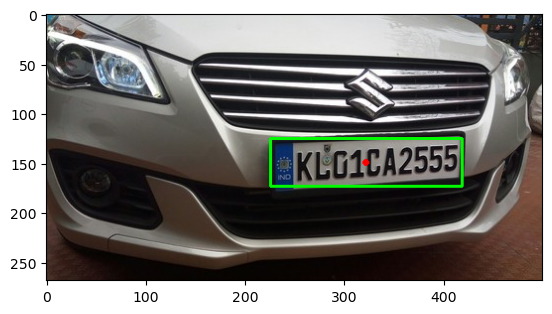

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread('./Car_License_Plate_Numbers/images/Cars0.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

rec = cv.rectangle(img, (226,125), (419,173), (0,250,0),2)
rec = cv.circle(rec, ((226+419)//2,(125+173)//2), 2, (255,0,0),2)
plt.imshow(rec)
plt.show()

## 2. Create Dataset

Since I am going to use Yolo model. I need to do some data preparation before training

Some requirements for data:

**1. dataset.yaml**

```python

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco128  # dataset root dir  
train: images/train2017  # (relative to 'path')
val: images/train2017  # (relative to 'path')  
test:  # (optional)
    
# Classes
names:  
  0: person  
  1: bicycle  
  2: car  
  ...
```

**2. label.txt**

One *.txt file per image (if no objects in image, no *.txt file is required). The *.txt file specifications are:
* One row per object
* Each row have the following format (seperate by space):  ```class x_center y_center width height```
* Box coordinates (xywh) must be normalized (between 0 and 1). If your boxes are in pixels, divide ```x_center``` and ```width``` by ```image width```, and ```y_center``` and ```height``` by ```image height```.
* Class numbers are zero-indexed (start from 0)

<img src="https://user-images.githubusercontent.com/26833433/112467037-d2568c00-8d66-11eb-8796-55402ac0d62f.png" alt= "label example" width=400 height=200>

**3. Directories organization**

<img src="https://user-images.githubusercontent.com/26833433/134436012-65111ad1-9541-4853-81a6-f19a3468b75f.png" alt= "directories example" width=600 height=500>

In [15]:
def normalized_coordinates(filename, width, height, xmin, ymin, xmax, ymax):
    """Take in image coordinates (unnormalized) as input, return normalized values 
    """
    
    xmin, xmax = xmin / width, xmax / width
    ymin, ymax = ymin / height, ymax/ height

    width = xmax-xmin
    height = ymax-ymin
    x_center = xmin + (width / 2)
    y_center = ymin + (height / 2)

    return x_center, y_center, width, height

def write_label(filename, x_center, y_center, width, height):
    #Save image's coordinates in text file named "filename"
    
    with open(filename, mode='w') as outf:
        outf.write(f"{0} {x_center} {y_center} {width} {height}\n")

def parse_xml_tags(data):
    """Parse xml label file, return image file name, and its coordinates as a dictionary
    """
    tags = ['filename', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']
    Bs_data = BeautifulSoup(data, "xml")
    d = dict()

    for t in tags:
        text = Bs_data.find(t).text
        if all(c.isdigit() for c in text):
            d[t] = int(text)
        else:
            d[t] = text
    return d

def build_data(dir_folder, ann_file_list, img_dir):
    """Write xml labels to text file with specifications format, save at 'labels' folder.
        Move image to 'images' folder
    """
    images_folder = f"{dir_folder}/images"
    labels_folder = f"{dir_folder}/labels"
    
    os.makedirs(images_folder, exist_ok = True)
    os.makedirs(labels_folder, exist_ok = True)


    for ann_file in ann_file_list:
        with open(ann_file, 'r') as f:
            label = parse_xml_tags(f.read())
         
        img_file_name = label['filename']
        x_center, y_center, width, height = normalized_coordinates(**label)
         
        # save at 'labels' folder
        write_label(f"{labels_folder}/{img_file_name.split('.')[0]}.txt", x_center, y_center, width, height)
         
         # Move image to 'images' folder
        shutil.copy(f"{img_dir}/{img_file_name}", f"{images_folder}/{img_file_name}")

In [16]:
import glob
dir_folder = "./plate_datasets"

ann_list = glob.glob('./Car_License_Plate_Numbers/annotations/*')
build_data(dir_folder, ann_list, "./Car_License_Plate_Numbers/images")

ann_list = glob.glob('./Automatic_NumberPlate_Recognition/images/*.xml')
build_data(dir_folder, ann_list, "./Automatic_NumberPlate_Recognition/images")

In [5]:
import yaml

data = {
    "path": dir_folder,
    "train": "images",
    "val": "",
    "names": {0: "car_lisence_plate"}
    }

with open('plate_datasets/dataset.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)
    
# path: /content/plate_data  # dataset root dir
# train: /content/plate_data/train/images  # (relative to 'path')
# val: /content/plate_data/val/images  # (relative to 'path')
# test:  # test images (optional)

# names:
#   0: no_car_plate
#   1: car_lisence_plate
#   2: car



In [6]:
assert len(os.listdir("plate_datasets/labels")) == len(os.listdir("plate_datasets/images"))

## 3. Train plate recognition model 
### Install model

In [7]:
%git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -r requirements.txt

UsageError: Line magic function `%git` not found.


### Train model

In [9]:
!python train.py --img 640 --batch 16 --epochs 50 --data plate_datasets/dataset.yaml \\ 
--weights yolov5s.pt --cache ram

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/plate_datasets/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with

### Load trained model

In [17]:
import torch

yolo = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5/runs/train/exp/weights/best.pt')



Using cache found in /Users/vivin/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-12 Python-3.10.12 torch-2.1.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### Inference

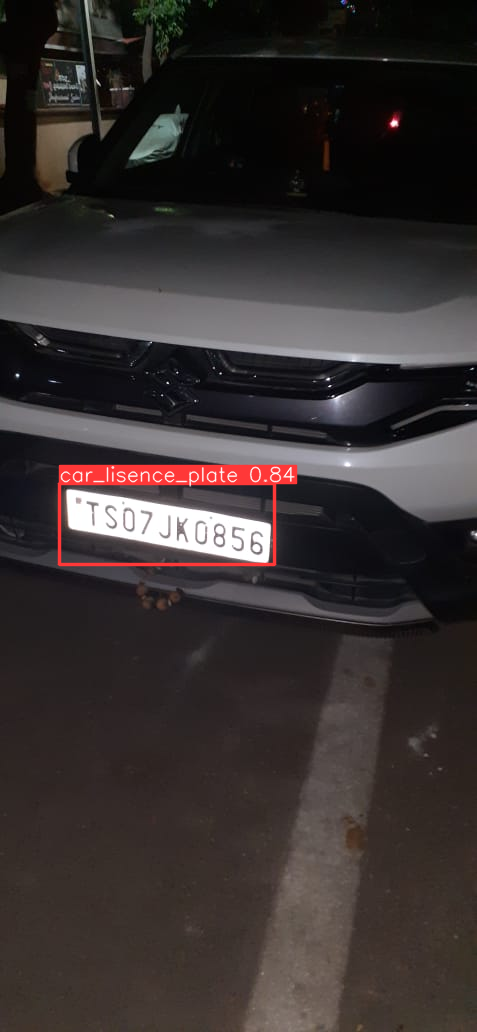

tensor([[ 59.52368, 483.91492, 274.97574, 564.74146,   0.84185]])


,xmin,ymin,xmax,ymax,confidence,class,name
0,59.523682,483.914917,274.975739,564.741455,0.841846,0,car_lisence_plate


In [20]:
img = './Automatic_NumberPlate_Recognition/TEST/flash_light.jpeg'
# Inference
results = yolo(img)
results.show()
cordinates = results.xyxy[0][:, :-1]
print(cordinates)
results.pandas().xyxy[0]

## 4. Extract Number Plate

### Install EasyOCR

In [12]:
%pip install easyocr -qq

Note: you may need to restart the kernel to use updated packages.


### Read Plate Number

In [21]:
def read_plate_number(results, frame, reader):
    n = len(results)
    x_shape, y_shape = frame.shape[1], frame.shape[0]

    for i in range(n):
        row = cordinates[i] # Iterate through each image
        if row[4] >= 0.5: ## Take img with 0.5 confidence
            xmin, ymin, xmax, ymax = row[:4]
            plate = frame[int(ymin):int(ymax), int(xmin):int(xmax)]

            ## Preprocess Plate
            gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)
            blurred = cv.bilateralFilter(gray, 17, 15, 15)
#             ret, thresh = cv.threshold(blurred, 125, 255, cv.THRESH_BINARY)

            ## OCR
            text = reader.readtext(blurred)
            text = ' '.join([t[1] for t in text])
            print("Number Plate: ", text)

            plot_img = frame.copy()

            cv.rectangle(plot_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2) ## BBox
            cv.rectangle(plot_img, (int(xmin), int(ymin-20)), (int(xmax), int(ymin)), (0, 255,0), -1) ## for text label background
            final_img = cv.putText(plot_img, f"{text}", (int(xmin), int(ymin)), cv.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
            
            return final_img

#             return cv.cvtColor(final_img, cv.COLOR_BGR2RGB)
#             cv.imwrite(f'/kaggle/working/labeled_img_{i}.jpg', cv.cvtColor(final_img, cv.COLOR_BGR2RGB))

Number Plate:  TS07 JK0856)


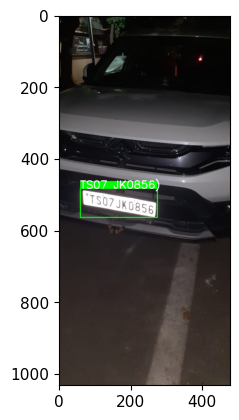

In [22]:
import matplotlib.pyplot as plt
import easyocr
import cv2 as cv
%matplotlib inline

reader = easyocr.Reader(['en'])
# cordinates = cordinates.cpu().numpy()

frame = cv.imread(img) ### reading the image
frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)

result_img = read_plate_number(cordinates, frame, reader)
plt.imshow(result_img)

plt.show()